<a href="https://colab.research.google.com/github/BasmaRG/3dcnn.torch/blob/master/Diagnoise_Covid_19_Chest_x_ray_with_acc_approx_97_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Libraries

In [ ]:
import cv2                 
import numpy as np         
import os                  
from random import shuffle
from tqdm import tqdm  
import tensorflow as tf 
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import glob as gb


In [ ]:
#read DataSet
TrianImage="/kaggle/input/chest-xray-covid19-pneumonia/Data/train/"
TestImage="/kaggle/input/chest-xray-covid19-pneumonia/Data/test/"


print(TrianImage)
print(TestImage)

/kaggle/input/chest-xray-covid19-pneumonia/Data/train/
/kaggle/input/chest-xray-covid19-pneumonia/Data/test/


In [ ]:
#to get all image names in train file
Pneumonaimages = os.listdir(TrianImage + "/PNEUMONIA")
Normalimages = os.listdir(TrianImage + "/NORMAL")
COVID19images = os.listdir(TrianImage + "/COVID19")

# # **Explore the Data**

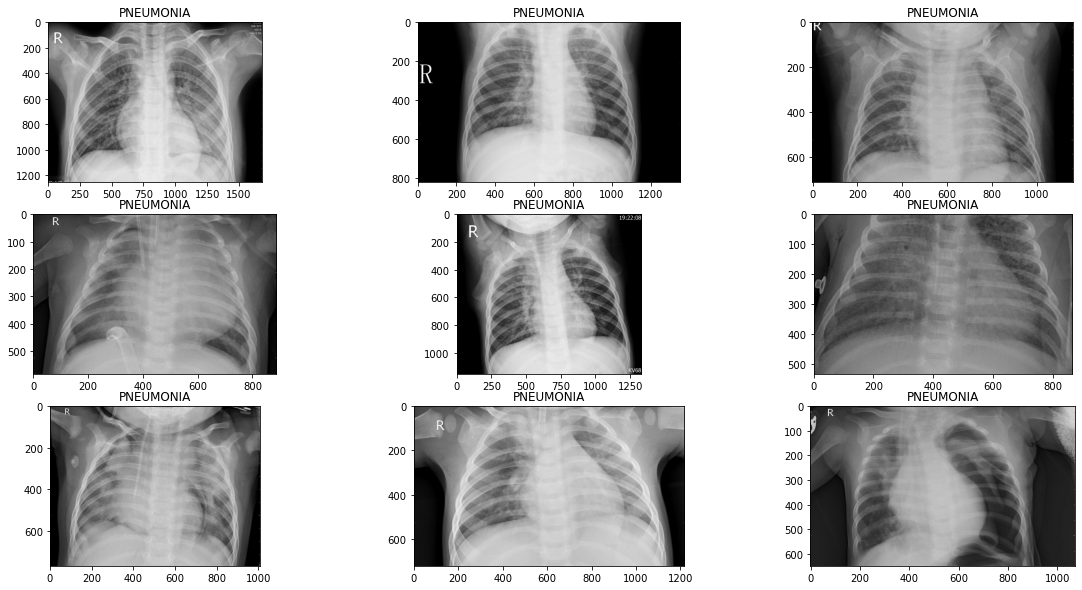

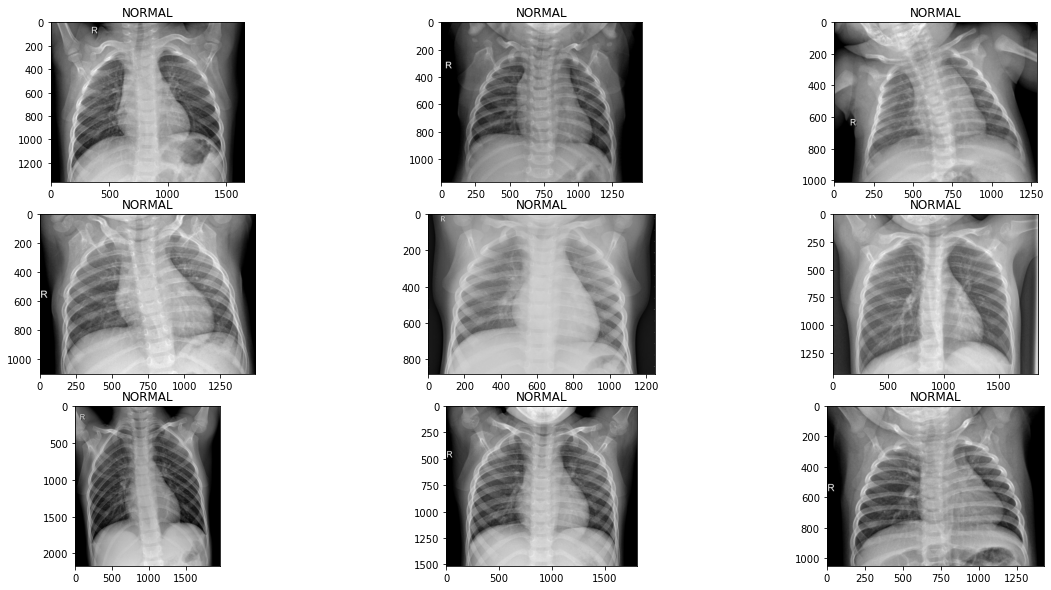

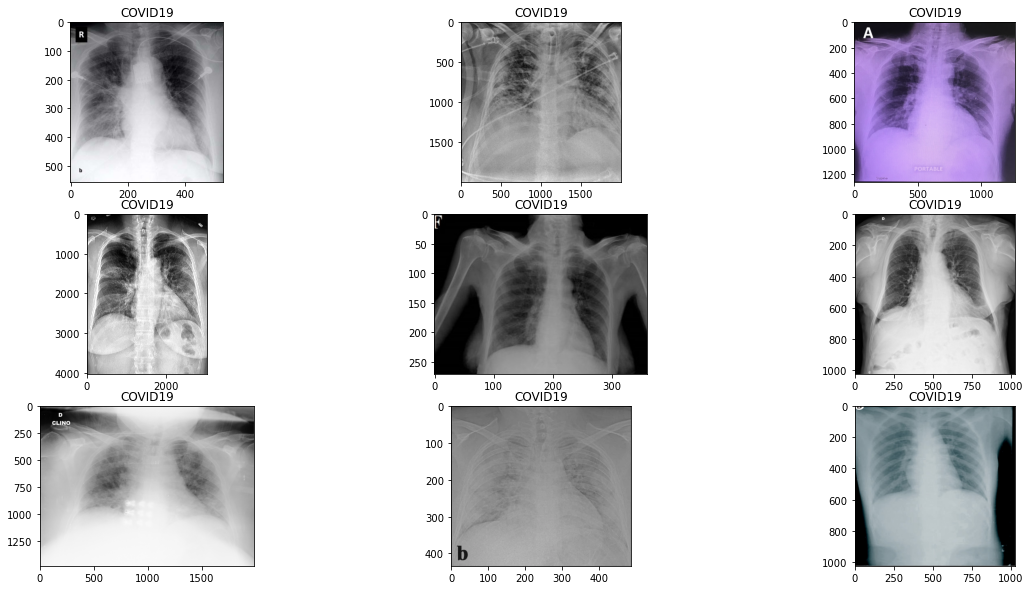

In [ ]:
#plot to show the size of some image
#plot PNEUMONIA
plt.figure(figsize=(20,10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join(TrianImage + "/PNEUMONIA",Pneumonaimages[i])),cmap='gray')
    plt.title("PNEUMONIA")
    
plt.show()
#plot NORMAL
plt.figure(figsize=(20,10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join(TrianImage + "/NORMAL",Normalimages[i])),cmap='gray')
    plt.title("NORMAL")

plt.show()
#plot 
plt.figure(figsize=(20,10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join(TrianImage + "/COVID19",COVID19images[i])),cmap='gray')
    plt.title("COVID19")

#ImageDataGenerator - DataAugmentation

We also use the generator to transform the values in each batch so that their mean is $0$ and their standard deviation is 1.
This will facilitate model training by standardizing the input distribution

The generator also converts our single channel X-ray images (gray-scale) to a three-channel format by repeating the values in the image across all channels.
We will want this because the pre-trained model that we'll use requires three-channel inputs.

In [ ]:
train_datagen = ImageDataGenerator(
      samplewise_center=True,
      samplewise_std_normalization= True,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      fill_mode='nearest'
                                  )

# NOTE: YOU MUST USE A BATCH SIZE OF 10 (batch_size=10) FOR THE 
# TRAIN GENERATOR.
train_generator =train_datagen.flow_from_directory(
     TrianImage,
     batch_size= 256,
     shuffle=shuffle,
     target_size=(300, 300)

)

test_generator =train_datagen.flow_from_directory(
     TestImage,
     batch_size= 50,
     shuffle=shuffle,
     target_size=(300, 300)

)


Found 5144 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.


# Explore Data After DataAugmentation and standardizing 

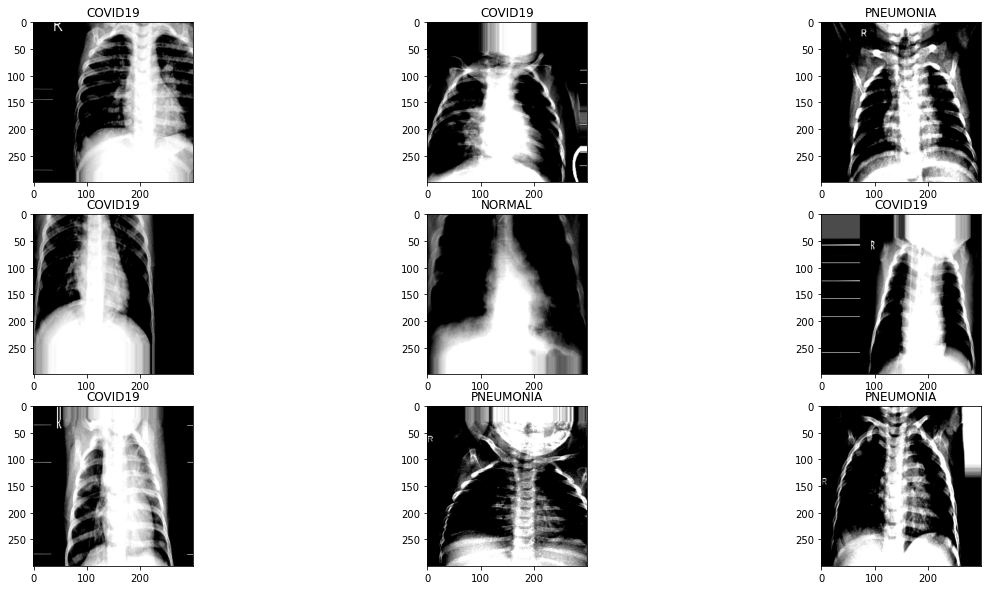

In [ ]:
plt.figure(figsize=(20,10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(train_generator.__getitem__(0)[0][i])
    plt.title(getLabel(np.argmax(train_generator.__getitem__(0)[1][i])) )

In [ ]:


Labels={'NORMAL':0,'PNEUMONIA':1,'COVID19':2}

# convert label to code
def getCode(label):
    return Labels[label]


# convert code to label 
def getLabel(n):
    for x,c in Labels.items():
        if n==c:
            return x
        
        
        
#Test        
print(getCode('COVID19'))
print(getLabel(1))

2
PNEUMONIA


In [ ]:
#Reading image data
import glob as gb
import cv2  
sizeImage=300 # to resize the all image as same size

#to read all images from directory
def getData(Dir,sizeImage):
    X=[]
    y=[]
    for folder in  os.listdir(Dir) : #to get the file name 
        files = gb.glob(pathname= str( Dir  +"/" +folder+ '//*.jpg' )) # to get the images
        for file in files:
                picture=cv2.imread(file) #  or plt.imread(file)
                imageArray=cv2.resize(picture,(sizeImage,sizeImage))
                X.append(list(imageArray))
                y.append(getCode(folder))
    X=np.array(X)
    y=np.array(y)
    return X,y




In [ ]:
# #get train data
X_train, y_train = getData(TrianImage,sizeImage)
# # get test data
X_test , y_test = getData(TestImage,sizeImage)



In [ ]:
#Convert y_train to categorical
y_train=to_categorical(y_train,3)
print("y_train ",y_train.shape)



#Convert y_train to categorical
y_test=to_categorical(y_test,3)
print("y_test ",y_test.shape)


y_test  (1288, 3)


In [ ]:
#load weight
Network_Weight="/kaggle/input/densenet-keras/DenseNet-BC-169-32-no-top.h5"
print(Network_Weight)

/kaggle/input/densenet-keras/DenseNet-BC-169-32-no-top.h5


In [ ]:
 
from tensorflow.keras.applications.densenet import DenseNet169
pre_trained_model = DenseNet169(input_shape = (sizeImage, sizeImage, 3), 
                                include_top = False, 
                                weights = None)
pre_trained_model.load_weights(Network_Weight)
for layer in pre_trained_model.layers:
    layer.trainable = False  #to make the layers to Freeze Weights
pre_trained_model.summary()

Model: "densenet169"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 306, 306, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 150, 150, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 150, 150, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [ ]:
from tensorflow.keras import Model


x = tf.keras.layers.Flatten()(pre_trained_model.output)

#Full Connected Layers
x = tf.keras.layers.Dense(512, activation='relu')(x)
#Add dropout to avoid Overfit
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
#Add dropout to avoid Overfit
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)


x=tf.keras.layers.Dense(3, activation='sigmoid')(x)
       

model = Model( pre_trained_model.input, x) 

print(model.summary())
model.compile(optimizer='adam', loss="binary_crossentropy",metrics=['accuracy'])


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 306, 306, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 150, 150, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 150, 150, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

Total params: 81,825,475
Trainable params: 69,182,595
Non-trainable params: 12,642,880
__________________________________________________________________________________________________
None


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau , ModelCheckpoint
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=0.0001, patience=1, verbose=1)

filepath="transferlearning_weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [ ]:
epochs = 30
history = model.fit_generator(train_generator,steps_per_epoch=20,callbacks=[lr_reduce,checkpoint] ,
         epochs=epochs)


Epoch 1/30
20/20 [==============================] - 239s 12s/step - loss: 0.0627 - accuracy: 0.9677 - lr: 0.0010
Epoch 2/30
20/20 [==============================] - 240s 12s/step - loss: 0.0587 - accuracy: 0.9689 - lr: 0.0010
Epoch 3/30
20/20 [==============================] - 252s 13s/step - loss: 0.0572 - accuracy: 0.9713 - lr: 0.0010
Epoch 4/30
20/20 [==============================] - 237s 12s/step - loss: 0.0712 - accuracy: 0.9599 - lr: 0.0010
Epoch 5/30
20/20 [==============================] - 235s 12s/step - loss: 0.0795 - accuracy: 0.9585 - lr: 0.0010
Epoch 6/30
20/20 [==============================] - 238s 12s/step - loss: 0.0697 - accuracy: 0.9613 - lr: 0.0010
Epoch 7/30
20/20 [==============================] - 244s 12s/step - loss: 0.0679 - accuracy: 0.9660 - lr: 0.0010
Epoch 8/30
20/20 [==============================] - 242s 12s/step - loss: 0.0534 - accuracy: 0.9736 - lr: 0.0010
Epoch 9/30
20/20 [==============================] - 248s 12s/step - loss: 0.0527 - accuracy: 0.9

# Ploting

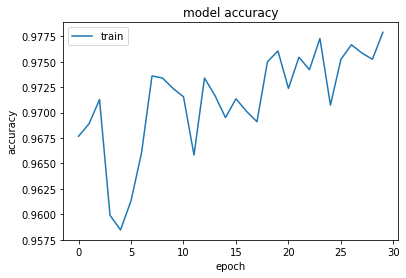

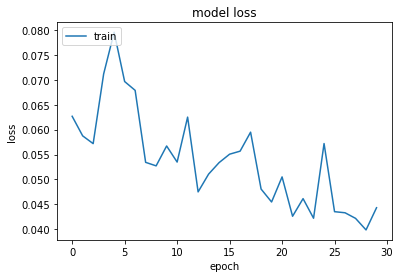

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [ ]:
#Evaluate Model
model.evaluate(test_generator)

26/26 [==============================] - 58s 2s/step - loss: 0.0569 - accuracy: 0.9713


[0.056861065328121185, 0.9712733030319214]

In [ ]:
model.save('modelCovid19___2.h5')

In [ ]:
#prediction
pred=model.predict(test_generator)

In [ ]:
print(len(pred))

1288


In [ ]:
y_test=[]
for i in range(26):
    y_test.extend(test_generator.__getitem__(i)[1])

In [ ]:
print(len(y_test))
y_test=np.array(y_test)

1288


In [ ]:
y_test=np.argmax(y_test,axis=1)
pred= np.argmax(pred,axis=1)

AxisError: axis 1 is out of bounds for array of dimension 1

In [ ]:
print("pred \n",len(pred))
print("y_test \n",len(y_test))

pred 
 1288
y_test 
 1288


In [ ]:
print("y_test \n",y_test)
print("pred \n",pred)

y_test 
 [1 2 1 ... 2 2 1]
pred 
 [1 2 1 ... 2 2 1]


In [ ]:
#confusion_matrix to check in accuracy 
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(pred,y_test)
print(cm)

[[115   0   1]
 [  0 305  24]
 [  1  12 830]]


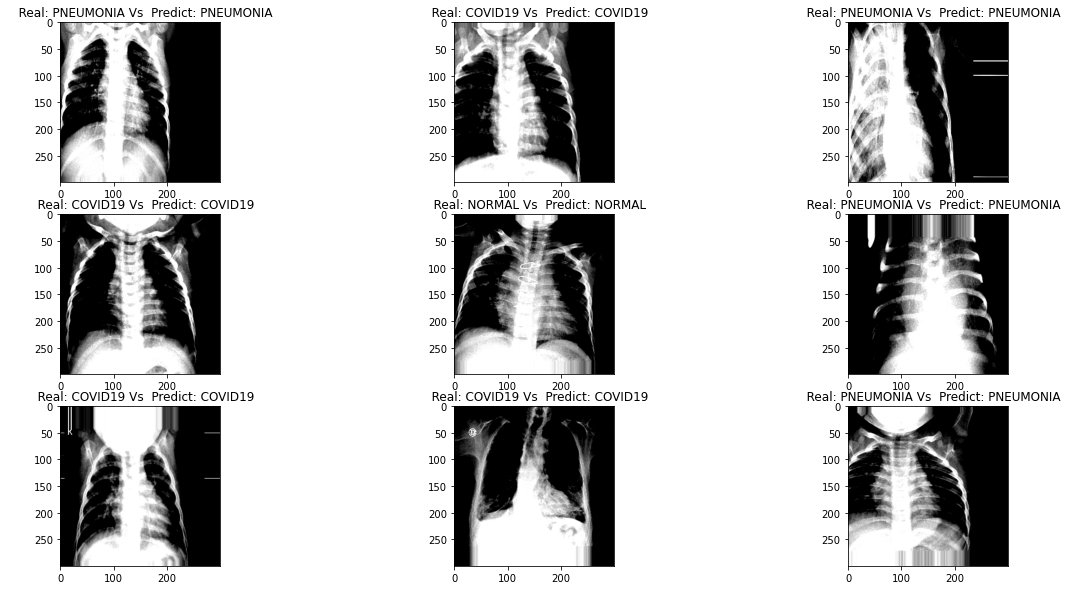

In [ ]:
plt.figure(figsize=(20,10))
for i in range(0,9):
    
    plt.subplot(3, 3, i + 1)
    
    plt.imshow(test_generator.__getitem__(0)[0][i],cmap='gray')
    plt.title(f"   Real: {getLabel(y_test[i])   } Vs  Predict: {getLabel(pred[i])}")

In [ ]:
#lto load model
from keras.models import load_model
loadedModel=load_model("modelCovid19___2.h5")

In [ ]:
loadedModel.compile(optimizer='adam', loss="binary_crossentropy",metrics=['accuracy'])
loadedModel.evaluate(test_generator)

26/26 [==============================] - 59s 2s/step - loss: 0.0583 - accuracy: 0.9736


[0.058339569717645645, 0.9736024737358093]